In [1]:
from data_processing import *
from model_training import *
import glob
import math
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import warnings
from os import path
warnings.filterwarnings("ignore")

In [14]:
columns = pd.read_csv('data/columns.txt', header=None)
columns_list = columns.transpose().values.tolist()[0]

sensors = ['lJPos', 'rJPos', 'lJVel',
           'rJVel', 'gyroX', 'gyroY', 'gyroZ', 'accX',
           'accY', 'accZ']

mode_pool = ['L0R0']
trial_pool = [1, 2, 3, 4, 5]
data_all = []

data_dir = 'data/'
for mode in mode_pool:
    for trial in trial_pool:
        file_path = data_dir+'log_'+str(mode)+'_'+str(trial)+'.txt'
        if path.exists(file_path) == 1:
            for read_path in glob.glob(file_path):
                data = pd.read_csv(read_path, sep=" ", header=None)
                data = data.iloc[:,0:15]
                data.columns = columns_list
                data = data[sensors]
                data_all.append(data)
data_list = label_data(data_all)

hyperparam_space = {
    'window_size': [40],
    'model': 'cnn',
    'cnn': {
      'kernel_size': [20],
      'activation': ['relu']
    },
    'dense': {
        'activation': ['tanh']
    },
    'optimizer': {
        'loss': ['mean_absolute_error'],
        'optimizer': ['Adam']
    },
    'training': {
        'epochs': [1],
        'batch_size': [128]
    }
}
hyperparameter_configs = get_model_configs(hyperparam_space)

In [22]:
# trial_results, average_results = train_models(hyperparam_space['model'], hyperparameter_configs, data_list)
learn, dataset = train_final_model(hyperparam_space['model'], hyperparameter_configs, data_list, 2)

(23093, 40, 10)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_5 (Normalizati (None, 40, 10)            21        
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 21, 10)            2010      
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 1, 10)             2110      
_________________________________________________________________
activation_4 (Activation)    (None, 1, 10)             0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 10)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 44        
Total params: 4,185
Trainable params: 4,164
Non-trainable params: 21
___________________________________

In [9]:
average_results.to_csv (r'C:\Users\Inseung Kang\Documents\GitHub\HipExo_GaitPhaseEstimation\average_results.csv', index = False, header=True)
trial_results.to_csv (r'C:\Users\Inseung Kang\Documents\GitHub\HipExo_GaitPhaseEstimation\trial_results.csv', index = False, header=True)

In [24]:
y_pred = learn.predict(dataset['X_test'])
y_true = dataset['y_test']

def gp_conv(y):
    gp_estimate_left = ((np.arctan2(y[:, 1], y[:, 0]) + (2.0*math.pi)) % (2.0*math.pi)) * 100/(2*math.pi)
    gp_estimate_right = ((np.arctan2(y[:, 3], y[:, 2]) + (2.0*math.pi)) % (2.0*math.pi)) * 100/(2*math.pi)
    return gp_estimate_left, gp_estimate_right

gp_pred_l, gp_pred_r = gp_conv(y_pred)
gp_true_l, gp_true_r = gp_conv(y_true)

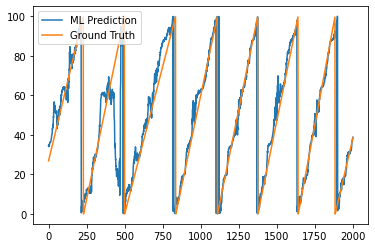

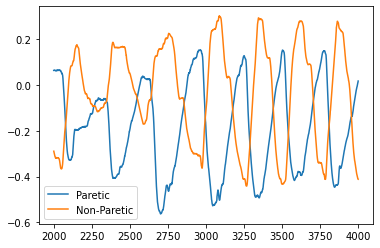

In [25]:
plt.plot(gp_pred_l[2000:4000], label = 'ML Prediction')
plt.plot(gp_true_l[2000:4000], label = 'Ground Truth')
plt.legend()
# plt.legend((gp_pred_l, gp_true_l), ('ML Predict', 'Ground Truth'))
plt.show()

plt.plot(data_list[2]['lJPos'][2000:4000], label = 'Paretic')
plt.plot(data_list[2]['rJPos'][2000:4000], label = 'Non-Paretic')
plt.legend()
plt.show()